<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/image_processing/stop_hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STOP táblák keresése képekben (esettanulmány)

Ebben az anyagban egy naiv algoritmust dolgzunk ki egy speciális feladat megoldására a számítógépes látás területén. A céunk a STOP táblák megtalálása a képekben.

Tervezett lépések:

* Piros pixelek szűrése a képből
* Piros területek konturjának kikeresése
* Nyolcszögletű alakzatok kikeresése


In [ ]:
from math import sqrt
import numpy as np
import skimage
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

Először töltsünk le egy STOP táblát tartalmazó képet az internetről és jelenítsük meg azt.

RGB kép egy (164, 245, 3) méretű mátrixban egész értékek (0, 255) között.
Piros: 0 - 255
Zöld:  0 - 219
Kék:   0 - 238


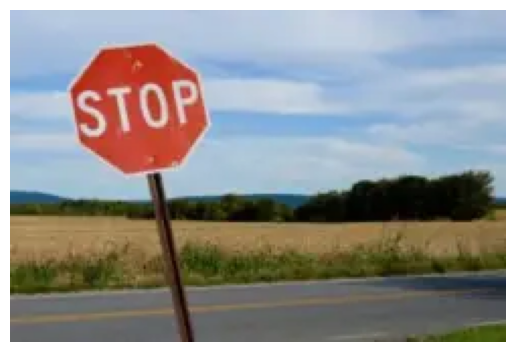

In [ ]:
img  = skimage.io.imread('https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp')
#img = skimage.io.imread('https://i0.wp.com/the-peak.ca/wp-content/uploads/2023/10/wgog2-scaled.jpg?fit=2560%2C1779&ssl=1')
# remove noise
#img = skimage.filters.gaussian(orig_img, 1)    # it may help
#img = orig_img
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')
print(f"RGB kép egy {img.shape} méretű mátrixban egész értékek (0, 255) között.")
print(f"Piros: {np.min(img[:,:,0])} - {np.max(img[:,:,0])}")
print(f"Zöld:  {np.min(img[:,:,1])} - {np.max(img[:,:,1])}")
print(f"Kék:   {np.min(img[:,:,2])} - {np.max(img[:,:,2])}")

Az RGB színtérben nem tudjuk egyszerűen kiválasztani a piros különböző árnyalatait. Ezért az RGB képet HSV színtérbe alakítjuk át. Az skimage a HSV értékeket a 0-1 tartományba alakítja át.

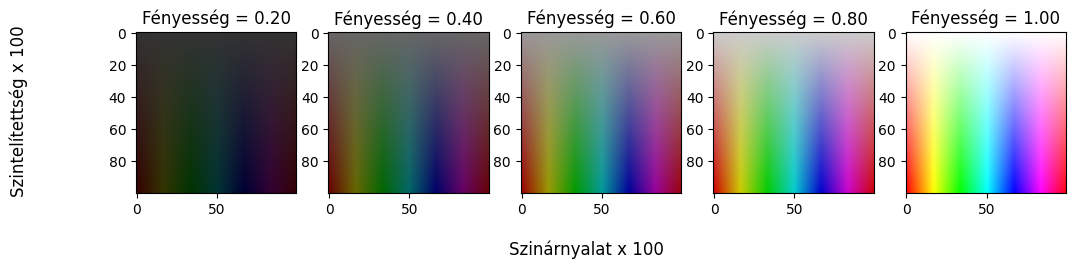

In [ ]:
isize = 100
h_scale = np.zeros((isize, isize, 3), dtype='float64')
h = np.arange(0.0, 1.0, 1 / h_scale.shape[1])
for i in range(isize):
        h_scale[i,:,0] = h
        h_scale[:,i,1] = h
icols = 5
fig, ax = plt.subplots(ncols=icols, figsize=(12, 3))
fig.supxlabel('Szinárnyalat x 100')
fig.supylabel('Szintelítettség x 100')
for i in range(icols):
    v = i / icols + 0.20
    h_scale[:,:,2] = v
    ax[i].imshow(skimage.color.hsv2rgb(h_scale))
    ax[i].set_title(f'Fényesség = {v:.2f}')

A fenti képből felismerhetjük, hogy a szintelítettségnek 0.6-nál nagyobbnak, a szinárnyalatnak 0.-nél kisebbnek kelllennie piros szín esetén. A fényességnek 0.3-nál nagyobb legyen, hogy a nagyon sötér árnyalatokat elkerüljük. A kép területének 0.5%-ánál kisebb területeket és szigeteket töröljük

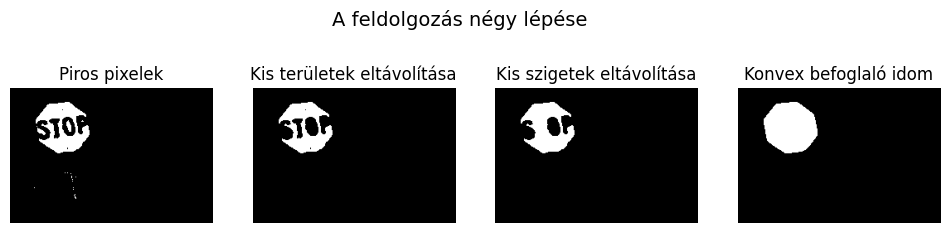

In [ ]:
img_hsv = skimage.color.rgb2hsv(img)
total_area = img.shape[0] * img.shape[1]
img1_bin = ((img_hsv[:,:,0] < 0.1) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,2] > 0.3) # red pixels
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
ax[0].set_title('Piros pixelek')
ax[0].imshow(img1_bin, cmap='gray')
ax[0].axis('off')
img2_bin = skimage.morphology.remove_small_objects(img1_bin, 0.005*total_area)
ax[1].set_title('Kis területek eltávolítása')
ax[1].imshow(img2_bin, cmap='gray')
ax[1].axis('off')
img3_bin = skimage.morphology.remove_small_holes(img2_bin, 0.005*total_area)
ax[2].set_title('Kis szigetek eltávolítása')
ax[2].imshow(img3_bin, cmap='gray')
ax[2].axis('off')
img4_bin = skimage.morphology.convex_hull_image(img3_bin) # nem megfelleő, ha több STOp tábla vana képen
ax[3].set_title('Konvex befoglaló idom')
ax[3].imshow(img4_bin, cmap='gray')
ax[3].axis('off')
_ = fig.suptitle('A feldolgozás négy lépése', fontsize=14)

A fenti fekete-fehér képeken a piros pixelek fehér az összes többi pixel fekete színnel jelenek meg.

A konvex körvonal képzése nem megfelő, ha több piros terület van a képen.

Zárt sokszöget képezünk a negyedik képen látható fehér terület körvonalából.

Stop tábla 63.8, 48.1


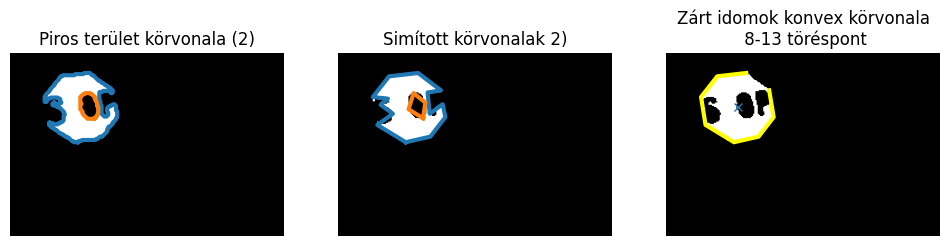

In [ ]:
cnts = skimage.measure.find_contours(img3_bin)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for i in range(3):
    ax[i].imshow(img3_bin, cmap='gray')
ax[0].set_title(f"Piros terület körvonala ({len(cnts)})")
ax[0].axis('off')
ax[1].set_title(f"Simított körvonalak {len(cnts)})")
ax[1].axis('off')
ax[2].set_title("Zárt idomok konvex körvonala\n 8-13 töréspont")
ax[2].axis('off')
for contour in cnts:
    ax[0].plot(contour[:,1], contour[:,0], linewidth=3)
    appr = skimage.measure.approximate_polygon(contour, tolerance=5.0)
    ax[1].plot(appr[:,1], appr[:, 0], linewidth=3)
    hull = ConvexHull(appr)
    x = [appr[i,1] for i in hull.vertices]
    y = [appr[i,0] for i in hull.vertices]
    n = len(x)
    if 7 < n < 15:
        ax[2].plot(x, y, c='yellow', linewidth=3)
        center = sum(x) / n, sum(y) / n
        ax[2].plot(center[0], center[1], 'x', linewidth=3)
        print(f"Stop tábla {center[0]:.1f}, {center[1]:.1f}")

A bemutatott lépéseket függvényekbe írtuk át, azzal a bővítéssel, hogy több piros területet is kezeljen egy képen.

A piros területek körvonalait egyesével vizsgáljuk, így több STOP táblát is tudunk detektálni. Azt is vizsgáljuk, hogy a területek körvonala tartalmazza-e egymást.

In [ ]:
def area(poly):
    """ calculate area of the polygon given as numpy array or list
    """
    coords = np.array(poly)
    coords1 = np.vstack((coords, coords[0]))    # first point to last
    return abs(np.sum((coords1[:-1, 0] - coords1[1:, 0]) * (coords1[:-1, 1] + coords1[1:, 1]))) / 2

def perimeter(poly):
    """ calculate perimeter of polygon given as numpy array or list
    """
    coords = np.array(poly)
    coords1 = np.vstack((coords, coords[0]))    # first point to last
    return np.sum(np.sqrt(np.sum(np.square(np.diff(coords1, axis=0)), axis=1)))

def stop_signs(img, area_limit=0.005):
    """ find stop traffic signal in image
        returns a list with the positions of the possible stop traffic signals and the convex hull of them
    """
    total_area = img.shape[0] * img.shape[1]
    img_hsv = skimage.color.rgb2hsv(img)
    img_bin = ((img_hsv[:,:,0] < 0.1) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,2] > 0.3) # red pixels
    img_bin = skimage.morphology.remove_small_objects(img_bin, area_limit*total_area)
    img_bin = skimage.morphology.remove_small_holes(img_bin, area_limit*total_area)
    cnts = skimage.measure.find_contours(img_bin)
    res = []
    resp = []
    areas = []
    for contour in cnts:
        appr = skimage.measure.approximate_polygon(contour, tolerance=area_limit*max(img.shape))  # smooth border
        try:
            hull = ConvexHull(appr)
        except:
            continue
        if 6 < hull.vertices.shape[0] < 14:
            xy = appr[hull.vertices]
            contour_area = area(xy)
            contour_peri = perimeter(xy)
            a_p = sqrt(contour_area) / contour_peri     # shape parameter
            if contour_area / total_area > area_limit or \
                0.26 < a_p < 0.30: #    # skip small or narrow areas
                c = np.mean(xy, axis=0).reshape(1,2)
                # check if actual contour is inside a found one
                new = True
                for i, cent in enumerate(res):
                    if areas[i] > contour_area:
                        if skimage.measure.points_in_poly(c, resp[i])[0]:
                            new = False
                            break
                    else:
                        if skimage.measure.points_in_poly(res[i], xy)[0]:
                            res[i] = c
                            resp[i] = xy
                            areas[i] = contour_area
                            new = False
                            break
                if new:   # no overlaping
                    res.append(c)    # weight point of poly
                    resp.append(xy)
                    areas.append(contour_area)
    return res, resp

# Tesztelés

Először teszteljük a függvényünket az előzőekben használt képpel.

In [ ]:
stop_signs(img)[0]

[array([[53.13636364, 61.09090909]])]

A teszteléshez összegyűjtöttünk néhány képet az internetről.

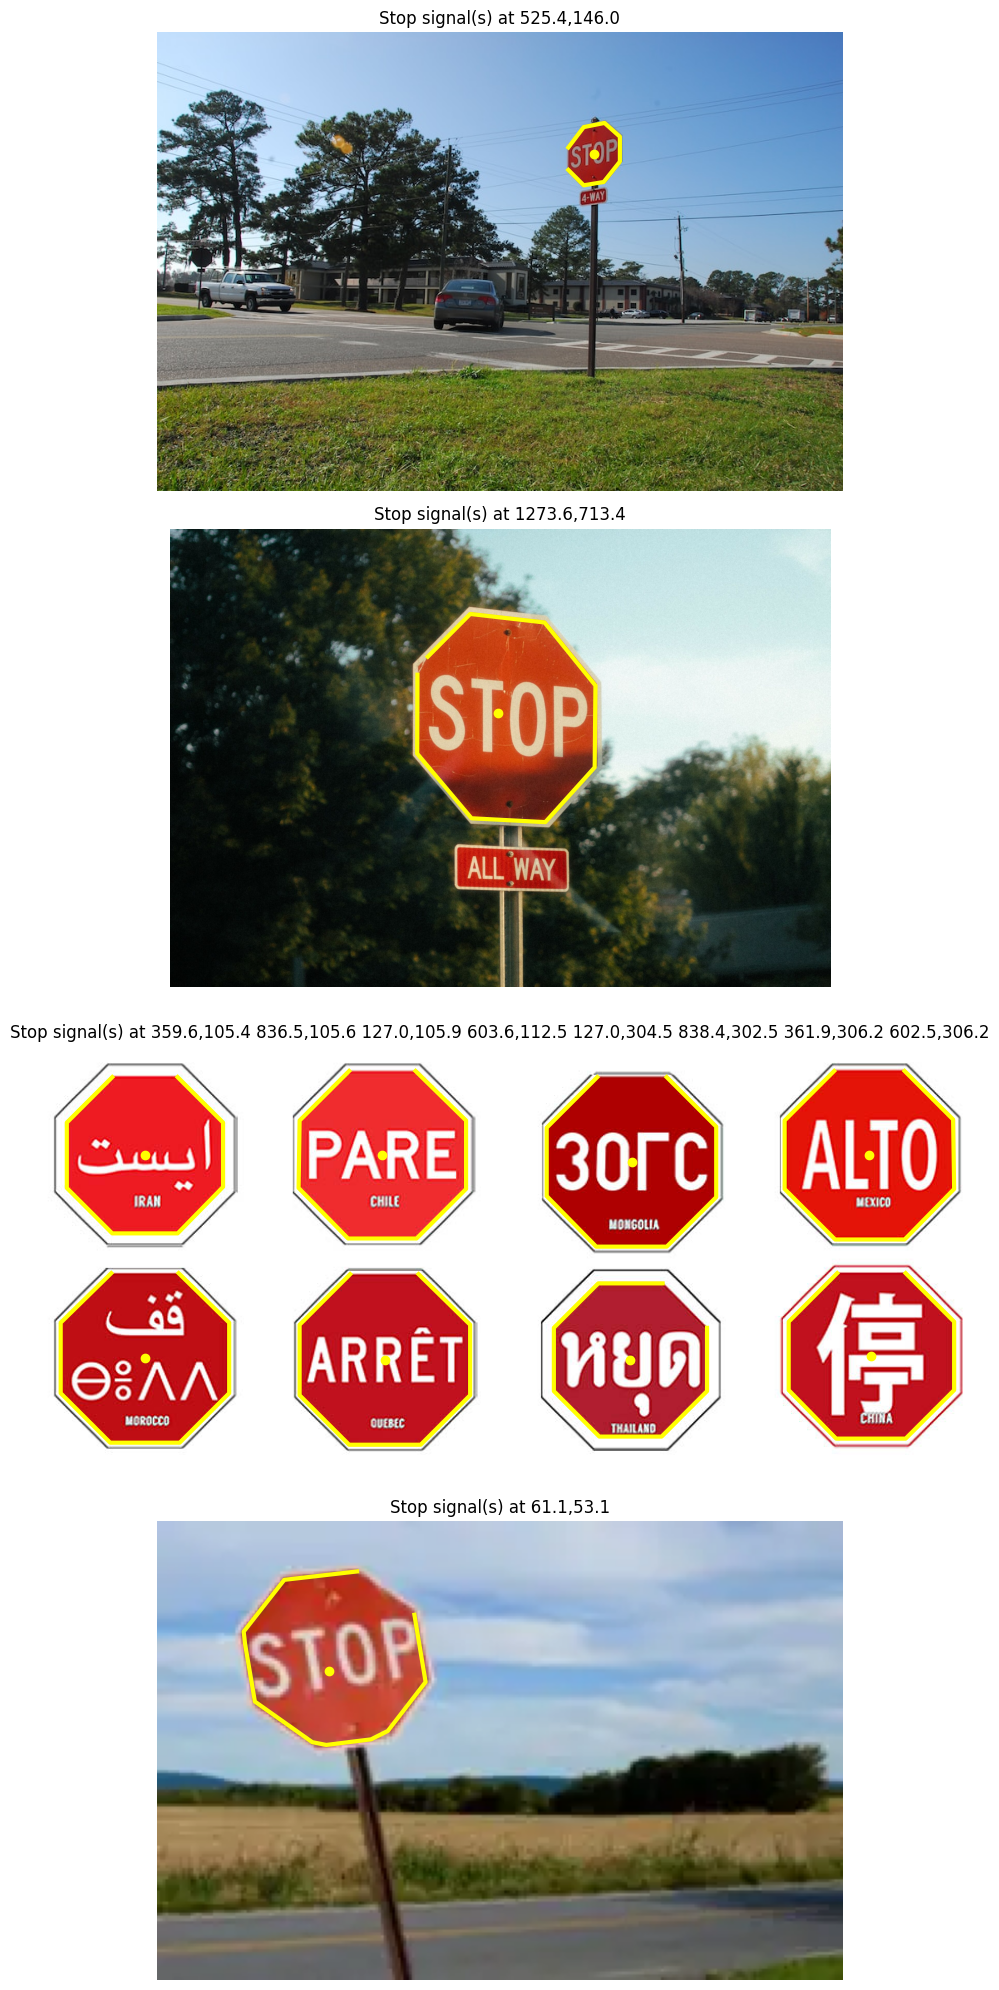

In [ ]:
img_paths = ['https://media.defense.gov/2009/Dec/08/2000417879/825/780/0/091207-F-5660L-009.JPG',
            'https://i0.wp.com/the-peak.ca/wp-content/uploads/2023/10/wgog2-scaled.jpg?fit=2560%2C1779&ssl=1',
            'https://www.frontsigns.com/wp-content/uploads/2018/06/Stop-traffic-signs.jpg',
             'https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp']
fig, ax = plt.subplots(nrows=len(img_paths), figsize=(10, 20))
for i, img_path in enumerate(img_paths):
    im = skimage.io.imread(img_path)
    ax[i].imshow(im)
    ax[i].axis('off')
    signs, polys = stop_signs(im)
    s = np.array(signs).reshape(-1,2)
    ax[i].plot(s[:,1], s[:,0], 'o', c="yellow")
    title = "Stop signal(s) at"
    for sign in signs:
        title += f" {sign[0,1]:.1f},{sign[0,0]:.1f}"
    for poly in polys:
        ax[i].plot(poly[:,1], poly[:,0], c="yellow", linewidth=3)
    ax[i].set_title(title)
plt.tight_layout(w_pad=3)

Ezekből a tesztekből láthatjuk, hogy a függvényünk jól működik.

#Feladatok

1. Tesztelje a függvényt újabb képekkel!
2. Bővítse a függvényt újabb táblatipus felismerésével.





# Záró gondoltok

A közlekedési táblák felismerése az önvezető járművek fejlesztésében. Ezt többnyire konvolúciós neurális hálózattal valósítják meg felügyelt mély tanulás segítségével. Ebben az esetben is a tábla separálása hasonló képfeldolgozási műveletekkel történik.